In [140]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

In [141]:
env = gym.make("CarRacing-v3")

In [142]:
obs, _ = env.reset()

In [143]:
obs.shape

(96, 96, 3)

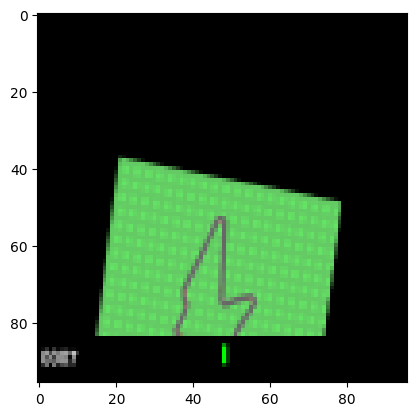

In [144]:
plt.imshow(obs)
plt.show()

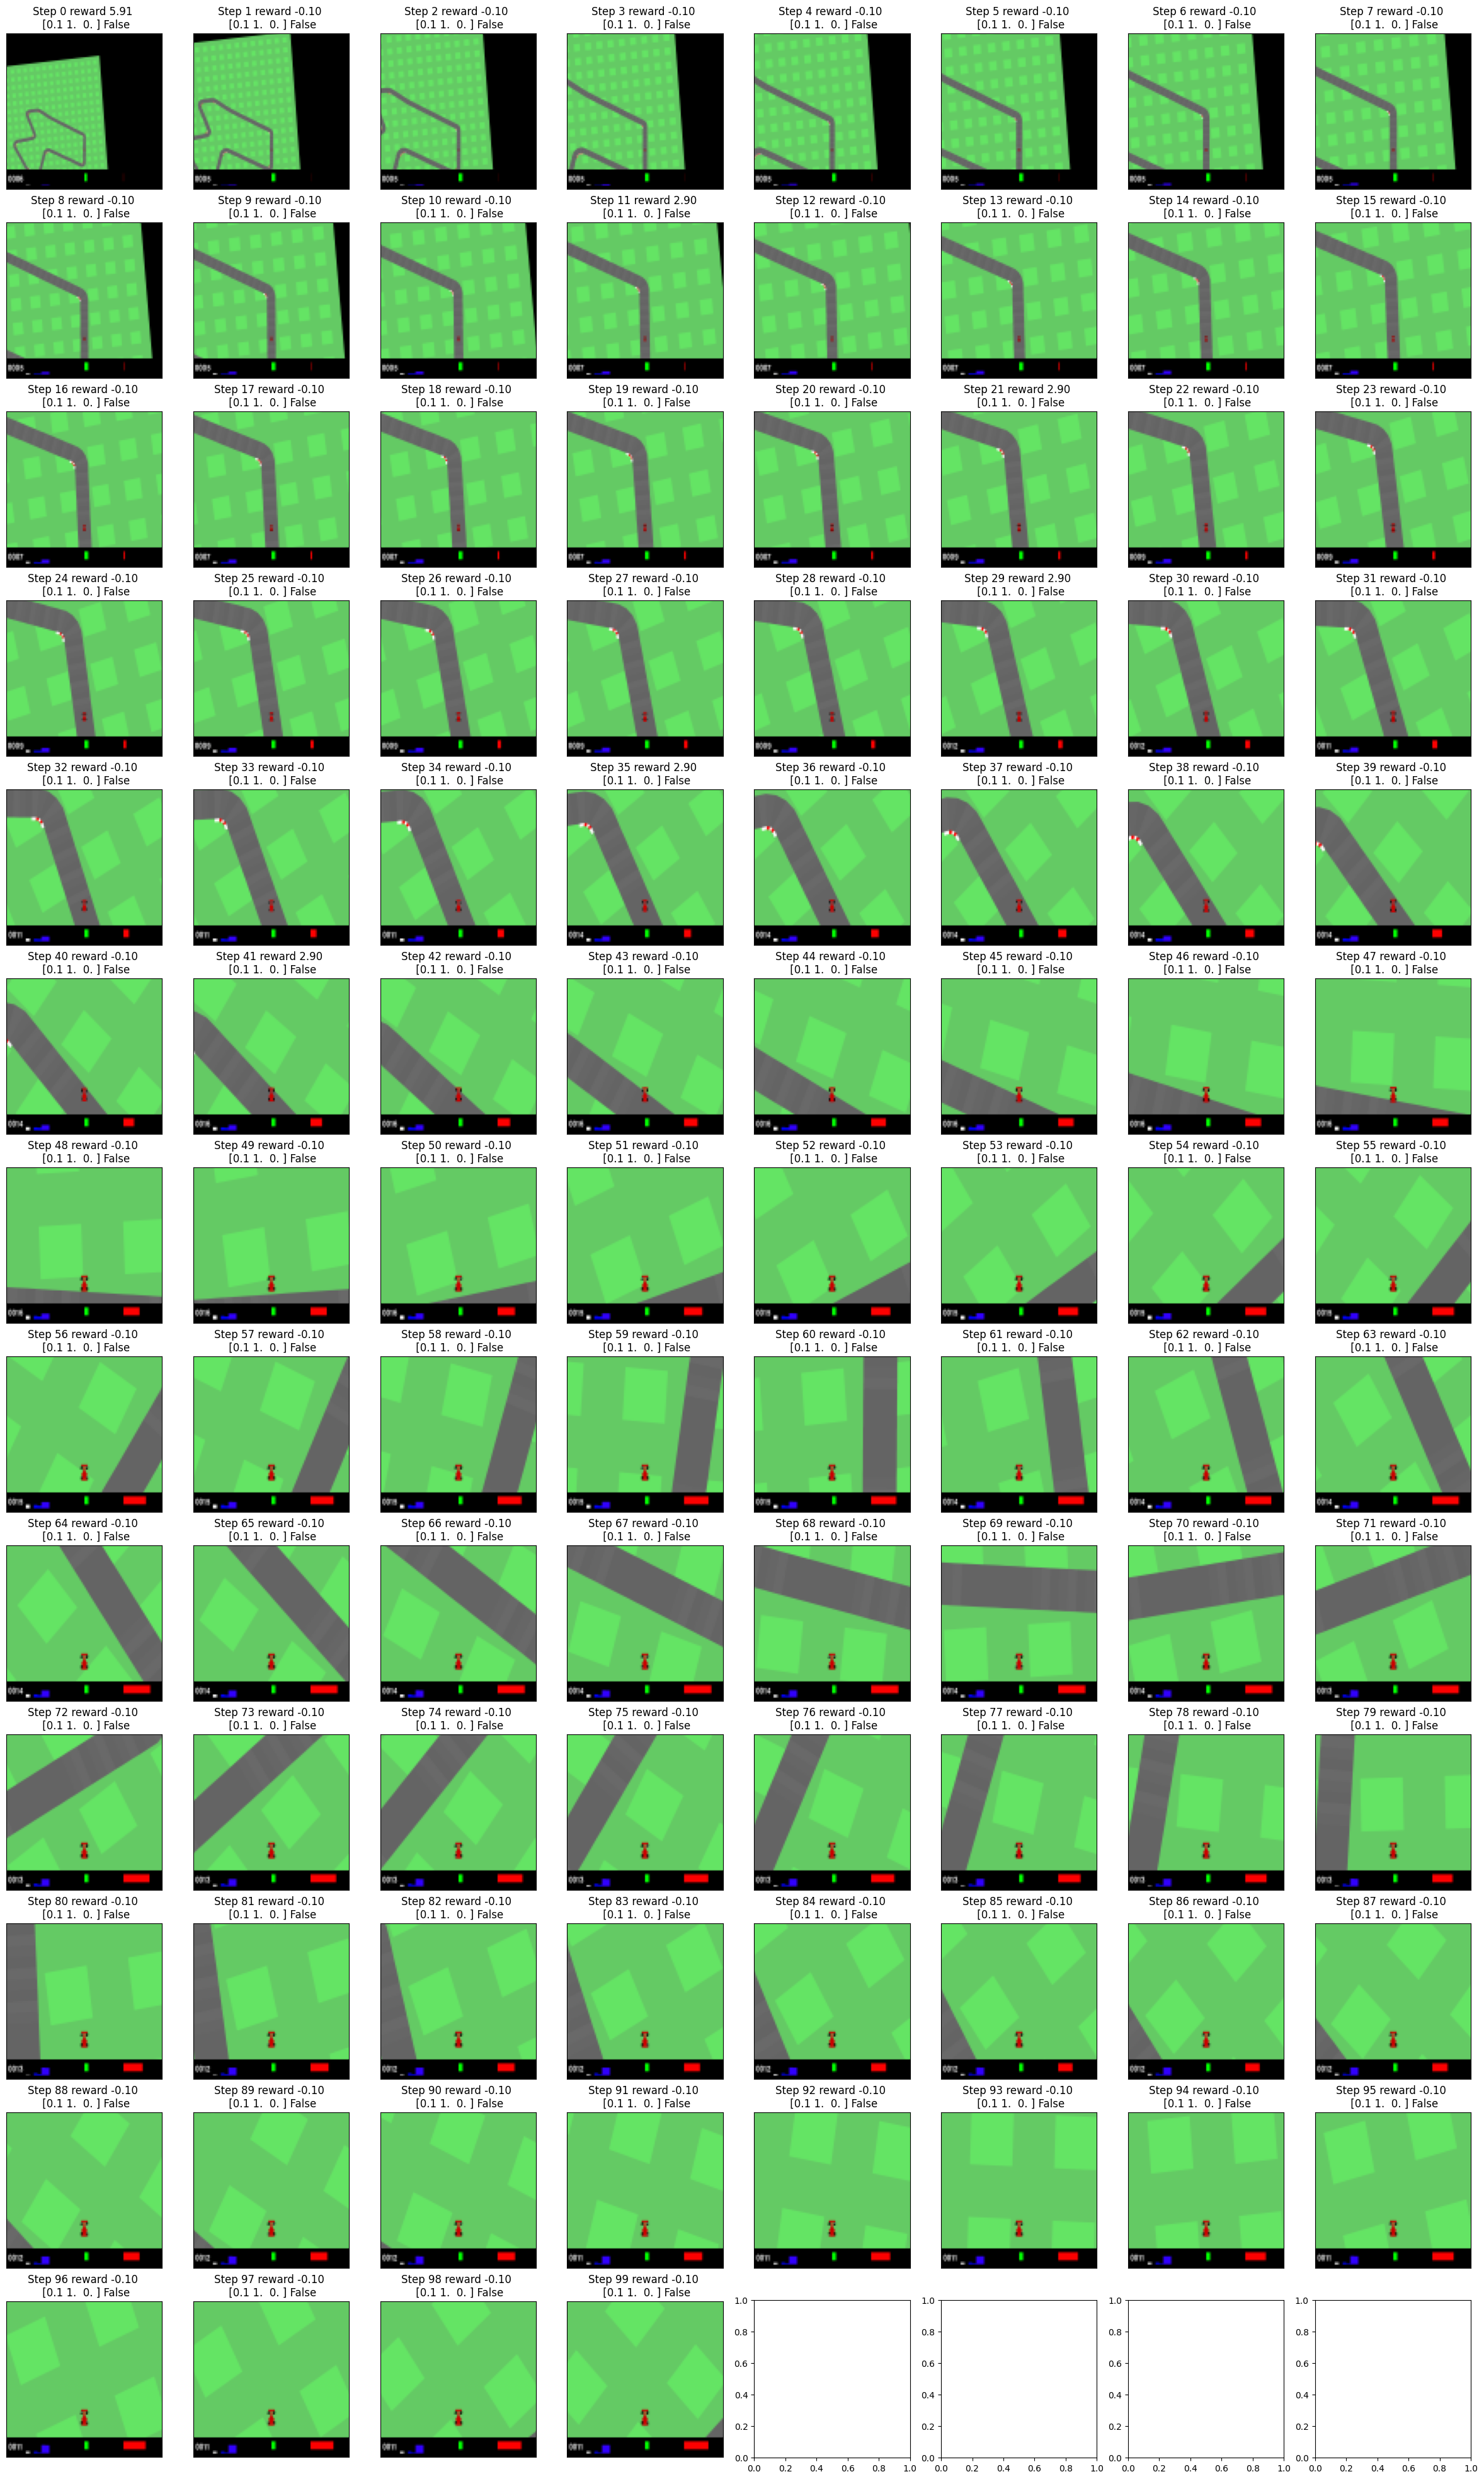

In [145]:
def show_episode(
    env,
    num_steps: int = 40,
    y_range: tuple | None = (64, 78),
    x_range: tuple | None = (43, 53),
    action: np.ndarray | None = None
) -> np.ndarray:
    fig, axs = plt.subplots(int(np.ceil(num_steps / 8)), 8, figsize=(30, num_steps//2))
    axs = axs.flatten()
    obs, _ = env.reset()

    y0, y1 = y_range if isinstance(y_range, tuple) else (0, obs.shape[0])
    x0, x1 = x_range if isinstance(x_range, tuple) else (0, obs.shape[1])

    for i in range(num_steps):
        if action is None:
            action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        patch = obs[y0:y1, x0:x1]
        axs[i].imshow(patch)
        axs[i].set_title(f"Step {i} reward {reward:.2f} \n {np.round(action,3)} {terminated or truncated}")
        axs[i].set_xticks([])
        axs[i].set_yticks([])

    plt.show()
    return obs
obs = show_episode(
    env,
    x_range=None,
    y_range=None,
    num_steps=100,
    action=np.array([0.1, 1., 0.])
)

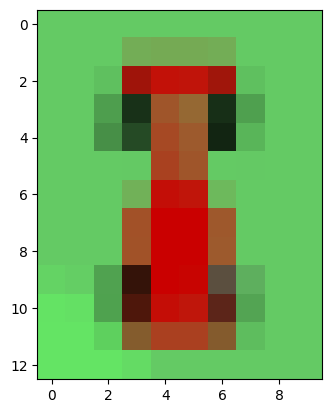

In [146]:
plt.imshow(obs[65:78, 43:53])

In [147]:
np.max(obs[40:50, 10:20], (0, 1)), np.min(obs[40:50, 10:20], (0, 1))

(array([100, 228, 100], dtype=uint8), array([100, 202, 100], dtype=uint8))

In [148]:
np.max(obs[66:78, 43:53], (0, 1)), np.min(obs[66:78, 43:53], (0, 1))

(array([202, 228, 100], dtype=uint8), array([18,  0,  0], dtype=uint8))

In [149]:
def image_border(
    obs: np.ndarray,
    y_range=(64, 78),
    x_range=(43, 53),
) -> np.ndarray:
    y0, y1 = y_range
    x0, x1 = x_range
    
    top = obs[y0, x0:x1, :]
    bottom = obs[y1, x0:x1, :]
    left = obs[(y0+1):(y1-1), x0]
    right = obs[(y0+1):(y1-1), x1]
    return np.concatenate([top, bottom, left, right], axis=0)

border = image_border(obs)
print(border.shape, border)

(44, 3) [[100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 228 100]
 [100 228 100]
 [100 228 100]
 [100 228 100]
 [100 216 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 211 100]
 [100 227 100]
 [100 228 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]
 [100 202 100]]


In [150]:
border > np.array([0, 120, 0])

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ T

In [ ]:
class OutOfTrackPenaltyAndTerminationWrapper(gym.Wrapper):
    def __init__(
        self,
        env,
        y_range=(64, 78),
        x_range=(43, 53),
        rgb_max_lim=np.array([120, 255, 120]),
        rgb_min_lim=np.array([0, 180, 0]),
        out_of_track_penalty=1,
        terminate_after=10,
        start_at_step=20,
        *args,
        **kwargs
    ):
        super().__init__(env)
        self.y_range = y_range
        self.x_range = x_range
        self.rgb_max_lim = rgb_max_lim
        self.rgb_min_lim = rgb_min_lim
        self.out_of_track_penalty = out_of_track_penalty
        self.terminate_after = terminate_after
        self.start_at_step = start_at_step
        self.step_counter = 0
        self.counter = 0
        self.current_penalty = 0

    def _border_check(self, obs) -> bool:
        border = image_border(obs, y_range=self.y_range, x_range=self.x_range)
        within_min = np.all(border >= self.rgb_min_lim, axis=1)
        within_max = np.all(border <= self.rgb_max_lim, axis=1)
        return np.all(within_min & within_max)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.step_counter = 0
        self.counter = 0
        self.current_penalty = 0
        return obs, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.step_counter += 1

        if self.step_counter < self.start_at_step:
            return obs, reward, terminated, truncated, info

        self.counter += 1

        out_of_track_check_result = self._border_check(obs)
        
        if not out_of_track_check_result:
            self.counter = 0
            self.current_penalty = 0
            return obs, reward, terminated, truncated, info

        self.current_penalty += self.out_of_track_penalty
        reward -= self.current_penalty

        if self.counter > self.terminate_after:
            terminated = True
            
        
        return obs, reward, terminated, truncated, info

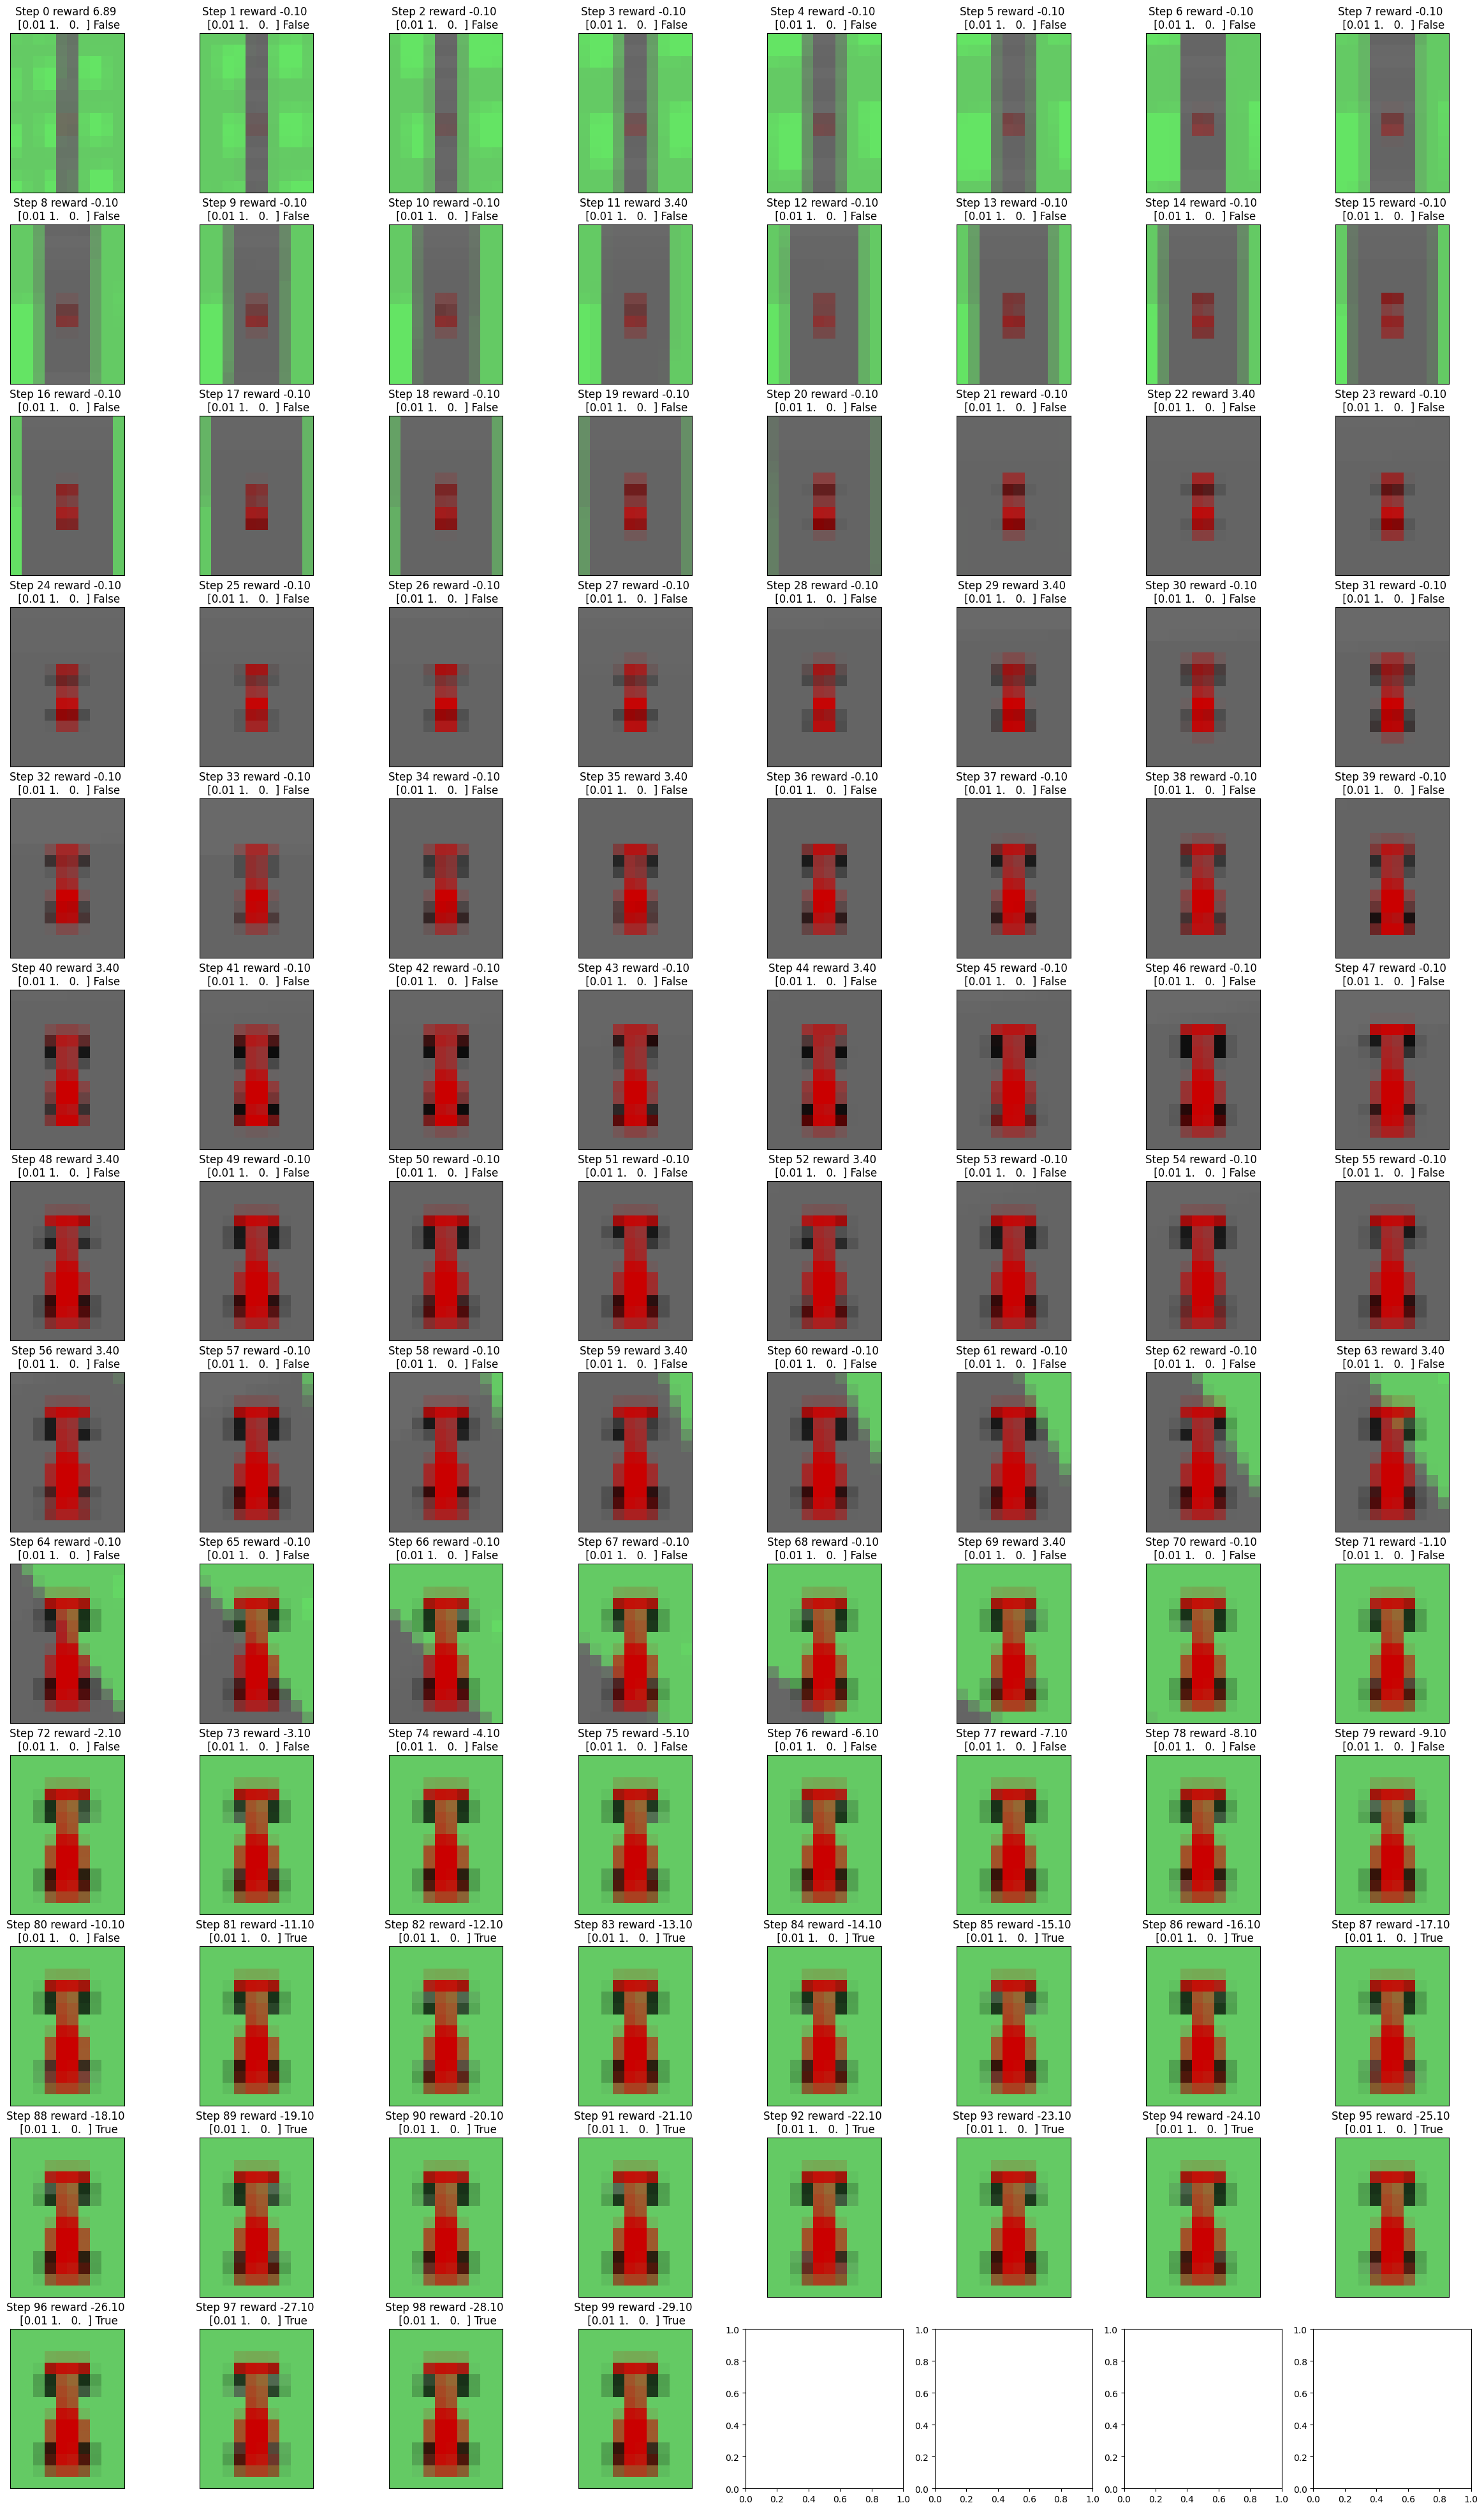

In [155]:
new_env = OutOfTrackPenaltyAndTerminationWrapper(env)
obs = show_episode(
    new_env,
    # x_range=None,
    # y_range=None,
    num_steps=100,
    action=np.array([0.01, 1., 0.])
)